# Managing Big Data for Connected Devices

## 420-N63-NA

## Kawser Wazed Nafi
 ----------------------------------------------------------------------------------------------------------------------------------

# Data Preprocessing and Selection of Features 
For example, we are going to use the following California Housing data set.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

#### Longitude
refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

#### Latitude 
refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

#### Housing Median Age
is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
#### Total Rooms
is the total number of rooms in the houses per block group

#### Total Bedrooms
is the total number of bedrooms in the houses per block group

#### Population
is the number of inhabitants of a block group

#### Households
refers to units of houses and their occupants per block group

#### Median Income
is used to register the median income of people that belong to a block group

#### Median House Value
is the dependent variable and refers to the median house value per block group



# Clustering Data

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). It is a main task of exploratory data analysis, and a common technique for statistical data analysis, used in many fields, including pattern recognition, image analysis, information retrieval, bioinformatics, data compression, computer graphics and machine learning.

Cluster analysis itself is not one specific algorithm, but the general task to be solved. It can be achieved by various algorithms that differ significantly in their understanding of what constitutes a cluster and how to efficiently find them. Popular notions of clusters include groups with small distances between cluster members, dense areas of the data space, intervals or particular statistical distributions. Clustering can therefore be formulated as a multi-objective optimization problem. The appropriate clustering algorithm and parameter settings (including parameters such as the distance function to use, a density threshold or the number of expected clusters) depend on the individual data set and intended use of the results. Cluster analysis as such is not an automatic task, but an iterative process of knowledge discovery or interactive multi-objective optimization that involves trial and failure. It is often necessary to modify data preprocessing and model parameters until the result achieves the desired properties.

Besides the term clustering, there is a number of terms with similar meanings, including automatic classification, numerical taxonomy, botryology (from Greek βότρυς "grape"), typological analysis, and community detection. The subtle differences are often in the use of the results: while in data mining, the resulting groups are the matter of interest, in automatic classification the resulting discriminative power is of interest.

## K-means Clustering

k-means is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters. k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, better Euclidean solutions can be found using k-medians and k-medoids.

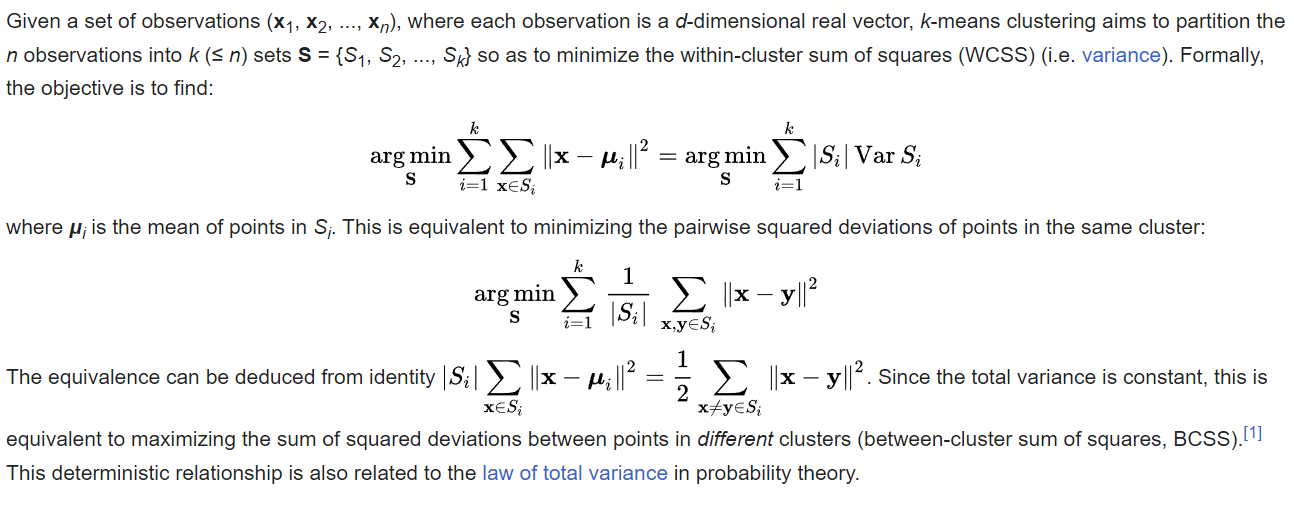



#### Step 1: Initialize the Spark Session and Importing the Libraries

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Logistic-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

# show the dataframe columns
housing_df.columns

# show the schema of the dataframe
#housing_df.printSchema()

# run a sample selection
housing_df.select('pop','totbdrms').show(10)

# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)

result_df.show(10)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



#### Step 2: Data Loading and Preprocessing

In [2]:

# Summary of the data

(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())


# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)


# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# Re-order and select columns
housing_df = housing_df.select("medhv", 
                               "medage",
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")
## Feature group normalization
'''In Multinomial Regression classification, more than two classes can be classified. So, we need to create more classes/label data '''
housing_df = housing_df.withColumn("medhvRounded", 
                                   F.when((col("medhv") <=1), 0)
                                   .when((col("medhv") <= 2) & (col("medhv") > 1),1)
                                   .when((col("medhv") <= 3) & (col("medhv") > 2),2)
                                   .when((col("medhv") <= 4) & (col("medhv") > 3),3)
                                   .when((col("medhv") > 4),4))
housing_df.show(5)

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



'In Multinomial Regression classification, more than two classes can be classified. So, we need to create more classes/label data '

+-----+------+--------+------+--------+------+--------+--------+----------+------------+
|medhv|medage|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|medhvRounded|
+-----+------+--------+------+--------+------+--------+--------+----------+------------+
|4.526|  41.0|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|           4|
|3.585|  21.0|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|           3|
|3.521|  52.0|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|           3|
|3.413|  52.0|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|           3|
|3.422|  52.0|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|           3|
+-----+------+--------+------+--------+------+--------+--------+----------+------------+
only showing top 5 rows



#### Step 3: Feature Selection and K-means model creation

In [3]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(housing_df).transform(housing_df)
assembled_df = assembled_df.withColumn('label', col('medhvRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features")
finalized_df.show(n=5)

quality_udf = udf(lambda x: x, StringType())
housing_df = housing_df.withColumn("label", quality_udf("medhvRounded"))

# Re-order and select columns
housing_df = housing_df.select("totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage", "label")

from pyspark.ml.linalg import Vectors

# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])
transformed_df.show(5, truncate=False)

+-----+------+--------+------+--------+------+--------+--------+----------+------------+----------------+-----------+----------------+--------------+----------------+----------------+------------------+--------------+------------------------+-------------------+------------------------+----------------------+------------------------+------------------------+--------------------------+----------------------+----------------------------------------------------------------------------------------+-----+
|medhv|medage|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|medhvRounded|totbdrms_indexed|pop_indexed|houshlds_indexed|medinc_indexed|rmsperhh_indexed|popperhh_indexed|bdrmsperrm_indexed|medage_indexed|totbdrms_indexed_encoded|pop_indexed_encoded|houshlds_indexed_encoded|medinc_indexed_encoded|rmsperhh_indexed_encoded|popperhh_indexed_encoded|bdrmsperrm_indexed_encoded|medage_indexed_encoded|features                                                                            

#### Step 4: Feature Indexing Creation for better Mapping

In [4]:


# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed_df)

data = featureIndexer.transform(transformed_df)
data.show(5, True)

+--------------------+--------------------+
|            features|     indexedFeatures|
+--------------------+--------------------+
|[129.0,322.0,126....|[129.0,322.0,126....|
|[1106.0,2401.0,11...|[1106.0,2401.0,11...|
|[190.0,496.0,177....|[190.0,496.0,177....|
|[235.0,558.0,219....|[235.0,558.0,219....|
|[280.0,565.0,259....|[280.0,565.0,259....|
+--------------------+--------------------+
only showing top 5 rows



#### Step 5: Model Creation and Training Phase

In [5]:
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans(featuresCol="indexedFeatures", k=5)

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(transformed_df)

cluster = model.transform(transformed_df)

cluster.show()

+--------------------+--------------------+----------+
|            features|     indexedFeatures|prediction|
+--------------------+--------------------+----------+
|[129.0,322.0,126....|[129.0,322.0,126....|         0|
|[1106.0,2401.0,11...|[1106.0,2401.0,11...|         4|
|[190.0,496.0,177....|[190.0,496.0,177....|         0|
|[235.0,558.0,219....|[235.0,558.0,219....|         0|
|[280.0,565.0,259....|[280.0,565.0,259....|         0|
|[213.0,413.0,193....|[213.0,413.0,193....|         0|
|[489.0,1094.0,514...|[489.0,1094.0,514...|         0|
|[687.0,1157.0,647...|[687.0,1157.0,647...|         1|
|[665.0,1206.0,595...|[665.0,1206.0,595...|         1|
|[707.0,1551.0,714...|[707.0,1551.0,714...|         1|
|[434.0,910.0,402....|[434.0,910.0,402....|         0|
|[752.0,1504.0,734...|[752.0,1504.0,734...|         1|
|[474.0,1098.0,468...|[474.0,1098.0,468...|         0|
|[191.0,345.0,174....|[191.0,345.0,174....|         0|
|[626.0,1212.0,620...|[626.0,1212.0,620...|         1|
|[283.0,69

#### Step 6: Visualization

In [6]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=5, inputCol="features", outputCol="pca")
pca_model = pca.fit(transformed_df)
pca_transformed = pca_model.transform(transformed_df)

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

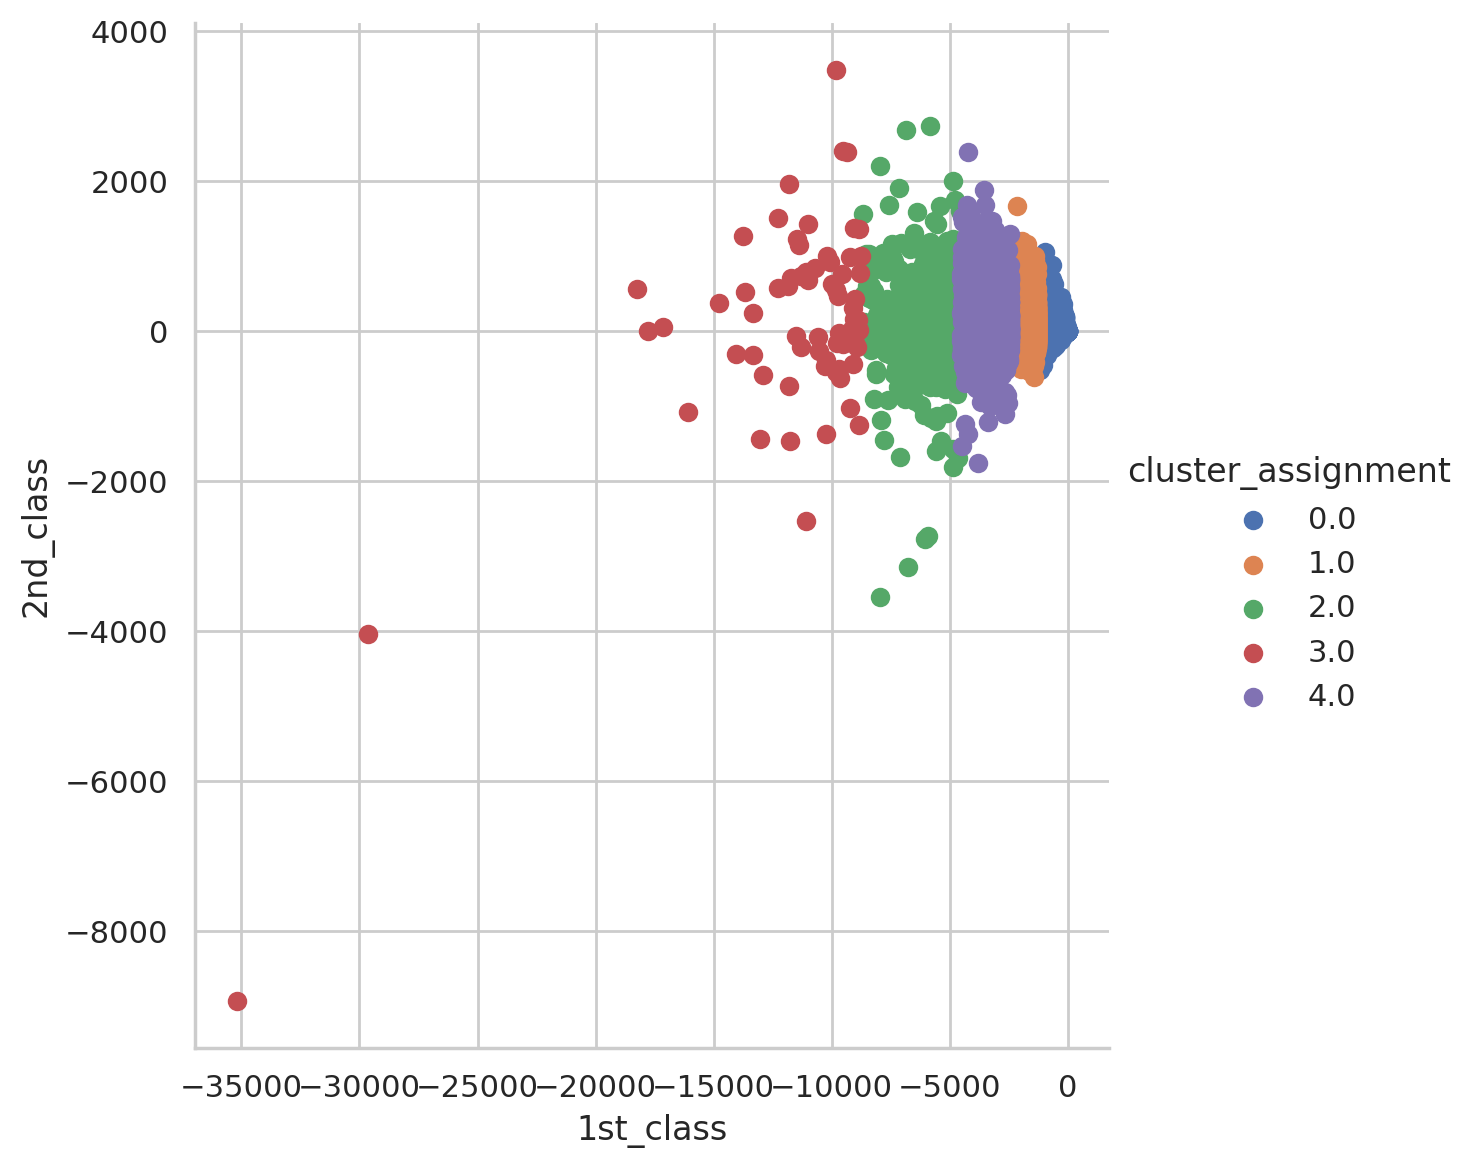

In [7]:
cluster_assignment = np.array(cluster.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_class", "2nd_class","3rd_class", "4th_class", "5th_class","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, "1st_class", "2nd_class").add_legend()

plt.show()

### Exercise 1:

Can we follow the same KMeans clustering steps for clustering the movies based on their average ratings?

In [41]:
moviesDF = ss.read.csv('Movies/movies.csv', header=True, inferSchema=True)
moviesDF.show(5, False)

ratingsDF = ss.read.csv('Movies/ratings.csv', header=True, inferSchema=True)
ratingsDF.show(5, False)

joinedDF = moviesDF.join(ratingsDF, 'movieId').groupBy('movieId').agg(F.avg(col('rating')).alias('avgRating'))
joinedDF.orderBy('movieId').show(truncate=False)

(joinedDF.describe().select(
                    "summary",
                    F.round("avgRating", 3).alias("avgRating"))
                    .show())

joinedDF = joinedDF.withColumn("avgRatingRounded", 
                                   F.when((col("avgRating") < 1), 0)
                                   .when((col("avgRating") < 2) & (col("avgRating") >= 1),1)
                                   .when((col("avgRating") < 3) & (col("avgRating") >= 2),2)
                                   .when((col("avgRating") < 4) & (col("avgRating") >= 3),3)
                                   .when((col("avgRating") < 5) & (col("avgRating") >= 4),4)
                                   .when((col("avgRating") >= 5),5))

joinedDF.orderBy('movieId').show(10)

featureCols = ["movieId", "avgRating"]

## Indexing creation for the featureCols .. This indexing gives us a mapping. 
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in featureCols]

# encoder creation
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers]

# Use a VectorAssembler to put features into a feature vector column:
# put features into a feature vector column
assembler = VectorAssembler(inputCols= [encoder.getOutputCol() for encoder in encoders], outputCol="features")
pipeline = Pipeline(stages=indexers + encoders + [assembler])
assembled_df= pipeline.fit(joinedDF).transform(joinedDF)
assembled_df = assembled_df.withColumn('label', col('avgRatingRounded'))
assembled_df.show(5, truncate=False)

finalized_df = assembled_df.select("features")
finalized_df.show(n=5, truncate=False)

quality_udf = udf(lambda x: x, StringType())
joinedDF = joinedDF.withColumn("label", quality_udf("avgRatingRounded"))

# Re-order and select columns
joinedDF = joinedDF.select("movieId", "avgRating", "label")

from pyspark.ml.linalg import Vectors

# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = joinedDF.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])
transformed_df.show(5, truncate=False)

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed_df)

data = featureIndexer.transform(transformed_df)
data.show(5, True)

from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans(featuresCol="indexedFeatures", k=2)

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(transformed_df)

cluster = model.transform(transformed_df)

cluster.show()


+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |1      |4.0   |964982703|
|1     |3      |4.0   |964981247|
|1  

+---------------------------+
|features                   |
+---------------------------+
|[1580.0,3.487878787878788] |
|[2366.0,3.64]              |
|[3175.0,3.58]              |
|[1088.0,3.369047619047619] |
|[32460.0,4.25]             |
|[44022.0,3.217391304347826]|
|[96488.0,4.25]             |
|[1238.0,4.055555555555555] |
|[1342.0,2.5]               |
|[1591.0,2.6346153846153846]|
|[1645.0,3.411764705882353] |
|[4519.0,3.3333333333333335]|
|[2142.0,2.7]               |
|[471.0,3.55]               |
|[3997.0,1.8333333333333333]|
|[833.0,2.0]                |
|[3918.0,3.2777777777777777]|
|[7982.0,3.25]              |
|[1959.0,3.6666666666666665]|
|[68135.0,3.55]             |
+---------------------------+
only showing top 20 rows



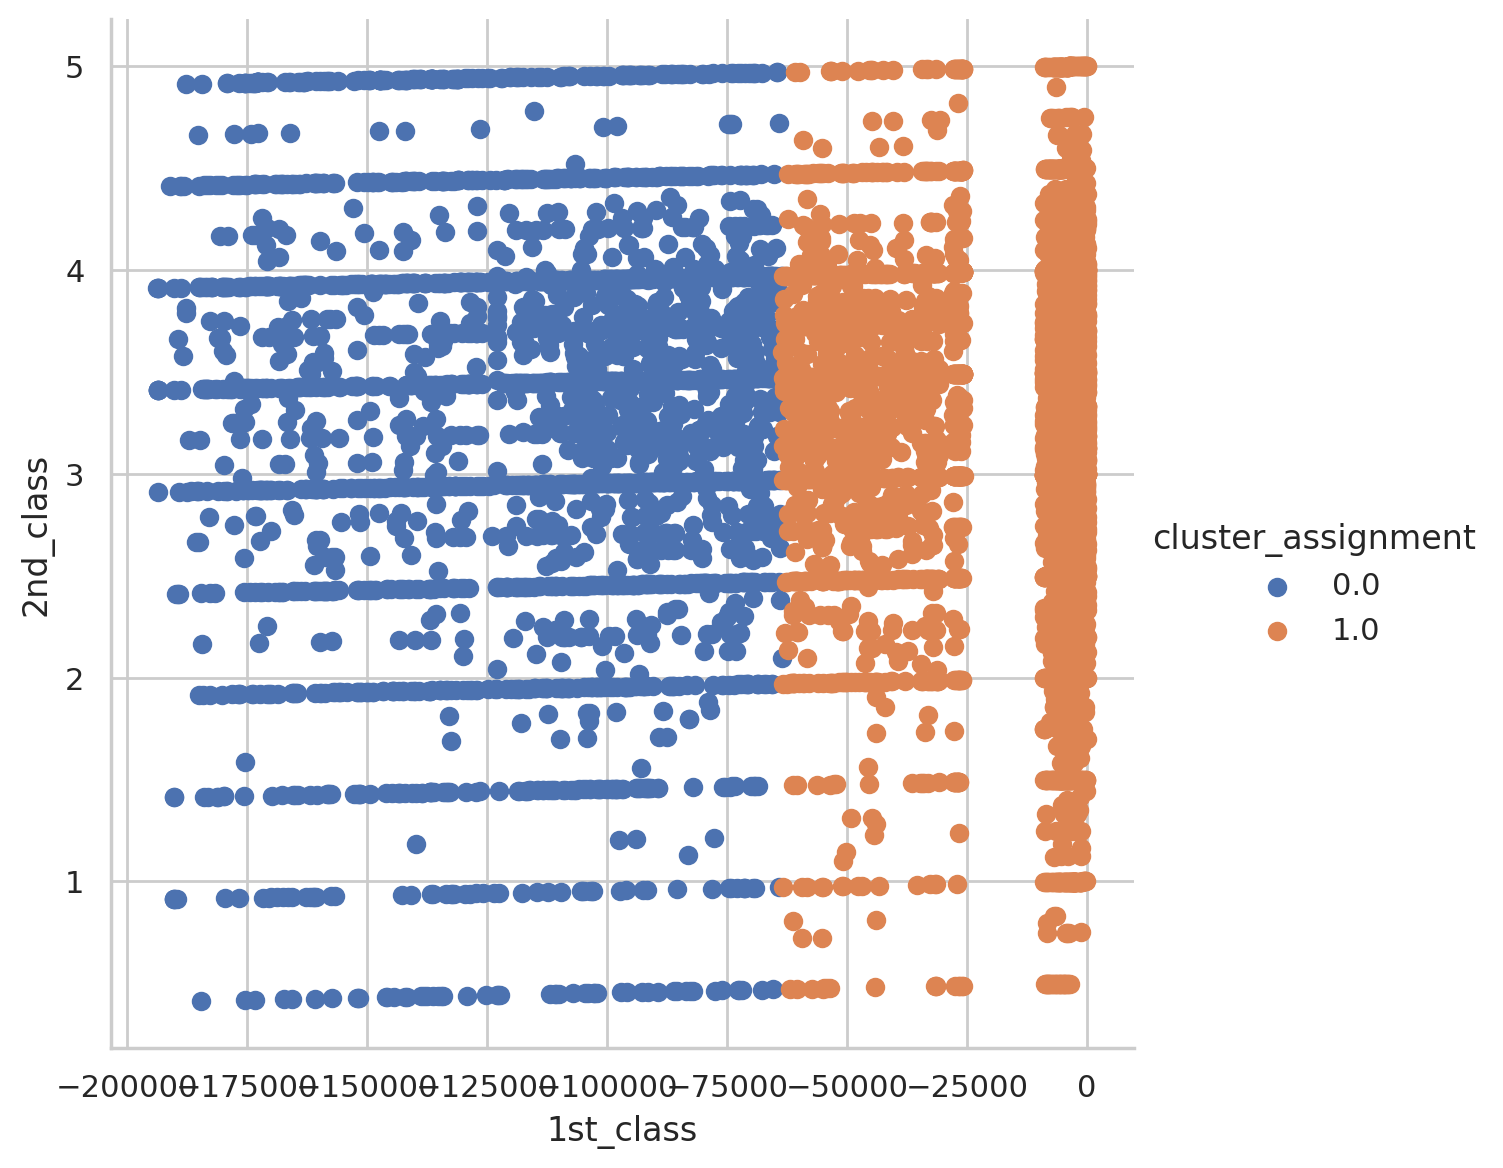

In [44]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")

transformed_df.show(truncate=False)
pca_model = pca.fit(transformed_df)
pca_transformed = pca_model.transform(transformed_df)

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(cluster.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_class", "2nd_class", "cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, "1st_class", "2nd_class").add_legend()

plt.show()

# Neural Network

A neural network is a method in artificial intelligence that teaches computers to process data in a way that is inspired by the human brain. It is a type of machine learning process, called deep learning, that uses interconnected nodes or neurons in a layered structure that resembles the human brain. It creates an adaptive system that computers use to learn from their mistakes and improve continuously. Thus, artificial neural networks attempt to solve complicated problems, like summarizing documents or recognizing faces, with greater accuracy.

Neural networks can help computers make intelligent decisions with limited human assistance. This is because they can learn and model the relationships between input and output data that are nonlinear and complex. For instance, they can do the following tasks.

### What are neural networks used for?
Neural networks have several use cases across many industries, such as the following:

<ul>
<li>Medical diagnosis by medical image classification </li>
<li>Targeted marketing by social network filtering and behavioral data analysis</li>
<li>Financial predictions by processing historical data of financial instruments</li>
<li>Electrical load and energy demand forecasting</li>
<li>Process and quality control</li>
<li>Chemical compound identification</li>
</ul>

### Computer vision
Computer vision is the ability of computers to extract information and insights from images and videos. With neural networks, computers can distinguish and recognize images similar to humans. Computer vision has several applications, such as the following:

#### Visual recognition in self-driving cars so they can recognize road signs and other road users
#### Content moderation to automatically remove unsafe or inappropriate content from image and video archives
#### Facial recognition to identify faces and recognize attributes like open eyes, glasses, and facial hair
#### Image labeling to identify brand logos, clothing, safety gear, and other image details

### Speech recognition
Neural networks can analyze human speech despite varying speech patterns, pitch, tone, language, and accent. Virtual assistants like Amazon Alexa and automatic transcription software use speech recognition to do tasks like these:

#### Assist call center agents and automatically classify calls
#### Convert clinical conversations into documentation in real time
#### Accurately subtitle videos and meeting recordings for wider content reach

### Natural language processing
Natural language processing (NLP) is the ability to process natural, human-created text. Neural networks help computers gather insights and meaning from text data and documents. NLP has several use cases, including in these functions:

#### Automated virtual agents and chatbots
#### Automatic organization and classification of written data
#### Business intelligence analysis of long-form documents like emails and forms
#### Indexing of key phrases that indicate sentiment, like positive and negative comments on social media
#### Document summarization and article generation for a given topic

### Recommendation engines
Neural networks can track user activity to develop personalized recommendations. They can also analyze all user behavior and discover new products or services that interest a specific user. For example, Curalate, a Philadelphia-based startup, helps brands convert social media posts into sales. Brands use Curalate’s intelligent product tagging (IPT) service to automate the collection and curation of user-generated social content. IPT uses neural networks to automatically find and recommend products relevant to the user’s social media activity. Consumers don't have to hunt through online catalogs to find a specific product from a social media image. Instead, they can use Curalate’s auto product tagging to purchase the product with ease.

### Step 1~5 Data Preprocessing and Transformation

In [8]:
### Step 1~5 Data Preprocessing and Transformation




# We need to transform the dataset to Dataframe so that each class can be seperated perfectly.
transformed_df = housing_df.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])
transformed_df.show(5, truncate=False)

+-----+------------------------------------------------------------+
|label|features                                                    |
+-----+------------------------------------------------------------+
|4    |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15,41.0]   |
|3    |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16,21.0]|
|3    |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13,52.0]    |
|3    |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18,52.0]   |
|3    |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17,52.0]  |
+-----+------------------------------------------------------------+
only showing top 5 rows



### Step 6 Training and Testing Data Creation 

In [9]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed_df)
labelIndexer.transform(transformed_df).show(5, True)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed_df)
featureIndexer.transform(transformed_df).show(5, True)

# Split the data into train and test (Keep 30% data for )
(trainingData, testData) = transformed_df.randomSplit([0.7, 0.3])
trainingData.show(5, True)
testData.show(5, True)

+-----+--------------------+------------+
|label|            features|indexedLabel|
+-----+--------------------+------------+
|    4|[129.0,322.0,126....|         4.0|
|    3|[1106.0,2401.0,11...|         3.0|
|    3|[190.0,496.0,177....|         3.0|
|    3|[235.0,558.0,219....|         3.0|
|    3|[280.0,565.0,259....|         3.0|
+-----+--------------------+------------+
only showing top 5 rows

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|    4|[129.0,322.0,126....|[129.0,322.0,126....|
|    3|[1106.0,2401.0,11...|[1106.0,2401.0,11...|
|    3|[190.0,496.0,177....|[190.0,496.0,177....|
|    3|[235.0,558.0,219....|[235.0,558.0,219....|
|    3|[280.0,565.0,259....|[280.0,565.0,259....|
+-----+--------------------+--------------------+
only showing top 5 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[4.0,9.0,5.0,1.62...|
|    0

In [10]:
### Step 7 Training Model Creation

In [11]:
### Step 7 Training Model Creation

layers = [8, 5 , 5, 4, 3, 5] 

'''
here, 
The first index of the layers represent number of input features, 

last index represents the number of output classes

rest of the inner indexes represents each layer individually with number of nodes/neurons on each layer. E.g. out first hidden layer consists of 5 nodes, 2nd 5 nodes, 3rd 4 nodes and 4th one 3 nodes
'''
from pyspark.ml.classification import MultilayerPerceptronClassifier

# create the trainer and set its parameters
FNN = MultilayerPerceptronClassifier(labelCol="indexedLabel", \
                                     featuresCol="indexedFeatures",\
                                     maxIter=100, layers=layers, \
                                     blockSize=128, seed=1234)
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, FNN, labelConverter])


# train the model
# Train model.  This also runs the indexers.


model = pipeline.fit(trainingData)

'\nhere, \nThe first index of the layers represent number of input features, \n\nlast index represents the number of output classes\n\nrest of the inner indexes represents each layer individually with number of nodes/neurons on each layer. E.g. out first hidden layer consists of 5 nodes, 2nd 5 nodes, 3rd 4 nodes and 4th one 3 nodes\n'

In [12]:
### Step 8 Model Predictions

# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)


+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[2.0,8.0,2.0,1.62...|    0|             1|
|[4.0,8.0,3.0,1.12...|    0|             1|
|[4.0,18.0,7.0,0.4...|    0|             1|
|[4.0,74.0,9.0,3.6...|    0|             1|
|[6.0,23.0,5.0,2.3...|    0|             1|
+--------------------+-----+--------------+
only showing top 5 rows



### Step 9 Evaluation

In [13]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Predictions accuracy = %g, Test Error = %g" % (accuracy,(1.0 - accuracy)))


Predictions accuracy = 0.387835, Test Error = 0.612165


MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_4b02594169d2, numLayers=6, numClasses=5, numFeatures=8


['1', '2', '0', '3', '4']

array([[1847,  630,    0,    0,    0],
       [ 936,  544,    0,    0,    0],
       [ 838,  269,    0,    0,    0],
       [ 250,  340,    0,    0,    0],
       [ 208,  303,    0,    0,    0]])

<Figure size 1800x400 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree Relation Confussion Matrix')

([<matplotlib.axis.XTick at 0x7ff45471c880>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '0'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

([<matplotlib.axis.YTick at 0x7ff45471d540>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '0'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

Text(0, 0, '1847')

Text(1004.5000000000002, 0.5, 'True label')

Text(0.5, 7.749107165632944, 'Predicted label')

Text(1, 0, '630')

Text(1087.728670612145, 0.5, 'True label')

Text(0.5, 12.44444444444443, 'Predicted label')

Text(2, 0, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 0, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 0, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 1, '936')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 1, '544')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 1, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 1, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 2, '838')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 2, '269')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 2, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 2, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 3, '250')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 3, '340')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 3, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 3, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(0, 4, '208')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(1, 4, '303')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(2, 4, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(3, 4, '0')

Text(1108.2842261677004, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

Text(4, 4, '0')

Text(1108.2842261677006, 0.5, 'True label')

Text(0.5, 33.0, 'Predicted label')

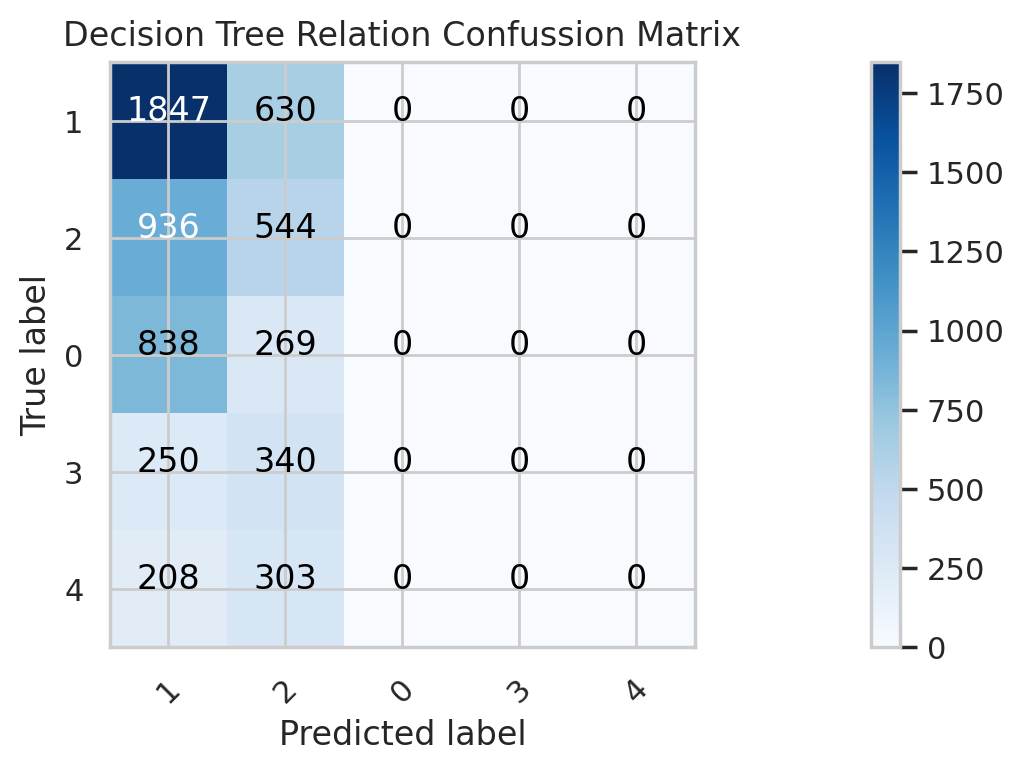

In [14]:
rfModel = model.stages[-2]
print(rfModel)

#trainingSummary.roc.show(5)
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = []
for i in range(0, len(class_temp)):
    class_names.append(str(class_temp[i]))
class_names

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
cnf_matrix

plt.figure()
cmap = plt.cm.Blues

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title("Decision Tree Relation Confussion Matrix")
plt.colorbar()
tick_makers = np.arange(len(class_temp))
plt.xticks(tick_makers, class_temp, rotation=45)
plt.yticks(tick_makers, class_temp)
thresh = cnf_matrix.max() /2
#fmt = '.2f'
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

# K- Nearest Neighbours

For this algorithm, we are going to use a new dataset, breast cancer as well as Python's another machine learning library, SciKit Learn. This Libray is a vast library and almost all the machine learning algorithms are available with implementation and trained model. 

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns

### Step 2 Loading dataset

In [16]:
df = pd.read_csv('breast-cancer.csv')
  
y = df['diagnosis']
X = df.drop('diagnosis', axis = 1)
X = X.drop('id', axis = 1)
# Separating the dependent and independent variable
  
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.3, random_state = 0)
# Splitting the data into training and testing data

### Step 3 Training the Model

In [17]:
K = []
training = []
test = []
scores = {}
  
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
  
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)
  
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]


KNeighborsClassifier(n_neighbors=2)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=4)

KNeighborsClassifier()

KNeighborsClassifier(n_neighbors=6)

KNeighborsClassifier(n_neighbors=7)

KNeighborsClassifier(n_neighbors=8)

KNeighborsClassifier(n_neighbors=9)

KNeighborsClassifier(n_neighbors=10)

KNeighborsClassifier(n_neighbors=11)

KNeighborsClassifier(n_neighbors=12)

KNeighborsClassifier(n_neighbors=13)

KNeighborsClassifier(n_neighbors=14)

KNeighborsClassifier(n_neighbors=15)

KNeighborsClassifier(n_neighbors=16)

KNeighborsClassifier(n_neighbors=17)

KNeighborsClassifier(n_neighbors=18)

KNeighborsClassifier(n_neighbors=19)

KNeighborsClassifier(n_neighbors=20)

### Step 4: Model Evaluation

In [18]:
### Step 4: Evaluating the model

for keys, values in scores.items():
    print(keys, ':', values)

2 : [0.9447236180904522, 0.9298245614035088]
3 : [0.9522613065326633, 0.9181286549707602]
4 : [0.9447236180904522, 0.9298245614035088]
5 : [0.9396984924623115, 0.9473684210526315]
6 : [0.9371859296482412, 0.9473684210526315]
7 : [0.9371859296482412, 0.9532163742690059]
8 : [0.9321608040201005, 0.9532163742690059]
9 : [0.9321608040201005, 0.9590643274853801]
10 : [0.9321608040201005, 0.9649122807017544]
11 : [0.9346733668341709, 0.9649122807017544]
12 : [0.9321608040201005, 0.9649122807017544]
13 : [0.9296482412060302, 0.9649122807017544]
14 : [0.9296482412060302, 0.9649122807017544]
15 : [0.9321608040201005, 0.9649122807017544]
16 : [0.9271356783919598, 0.9649122807017544]
17 : [0.9321608040201005, 0.9649122807017544]
18 : [0.9221105527638191, 0.9649122807017544]
19 : [0.9246231155778895, 0.9649122807017544]
20 : [0.9170854271356784, 0.9649122807017544]


### Step 5: Plotting the training and testing score graph

/tmp/ipykernel_13165/2147612412.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(x = K, y = training, palette="Set2");


[Text(0.5, 0, 'values of k'), Text(0, 0.5, 'Training Score')]

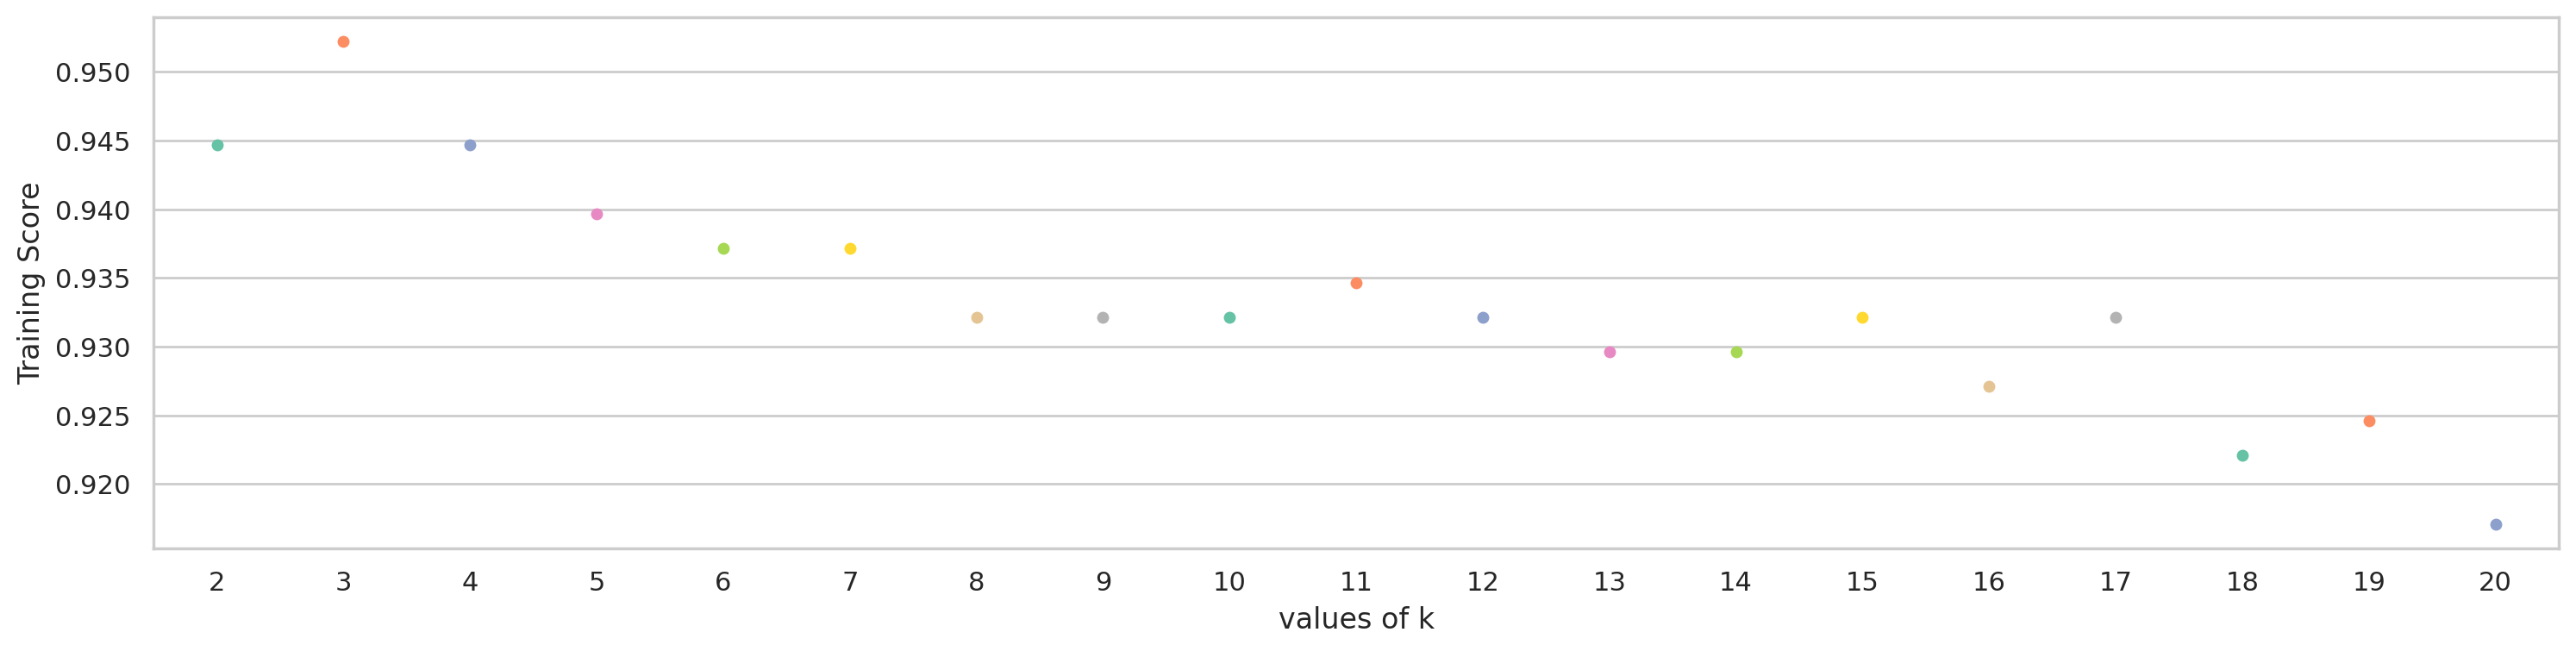

In [19]:
ax = sns.stripplot(x = K, y = training, palette="Set2");
ax.set(xlabel ='values of k', ylabel ='Training Score')  
  
plt.show()
# function to show plot

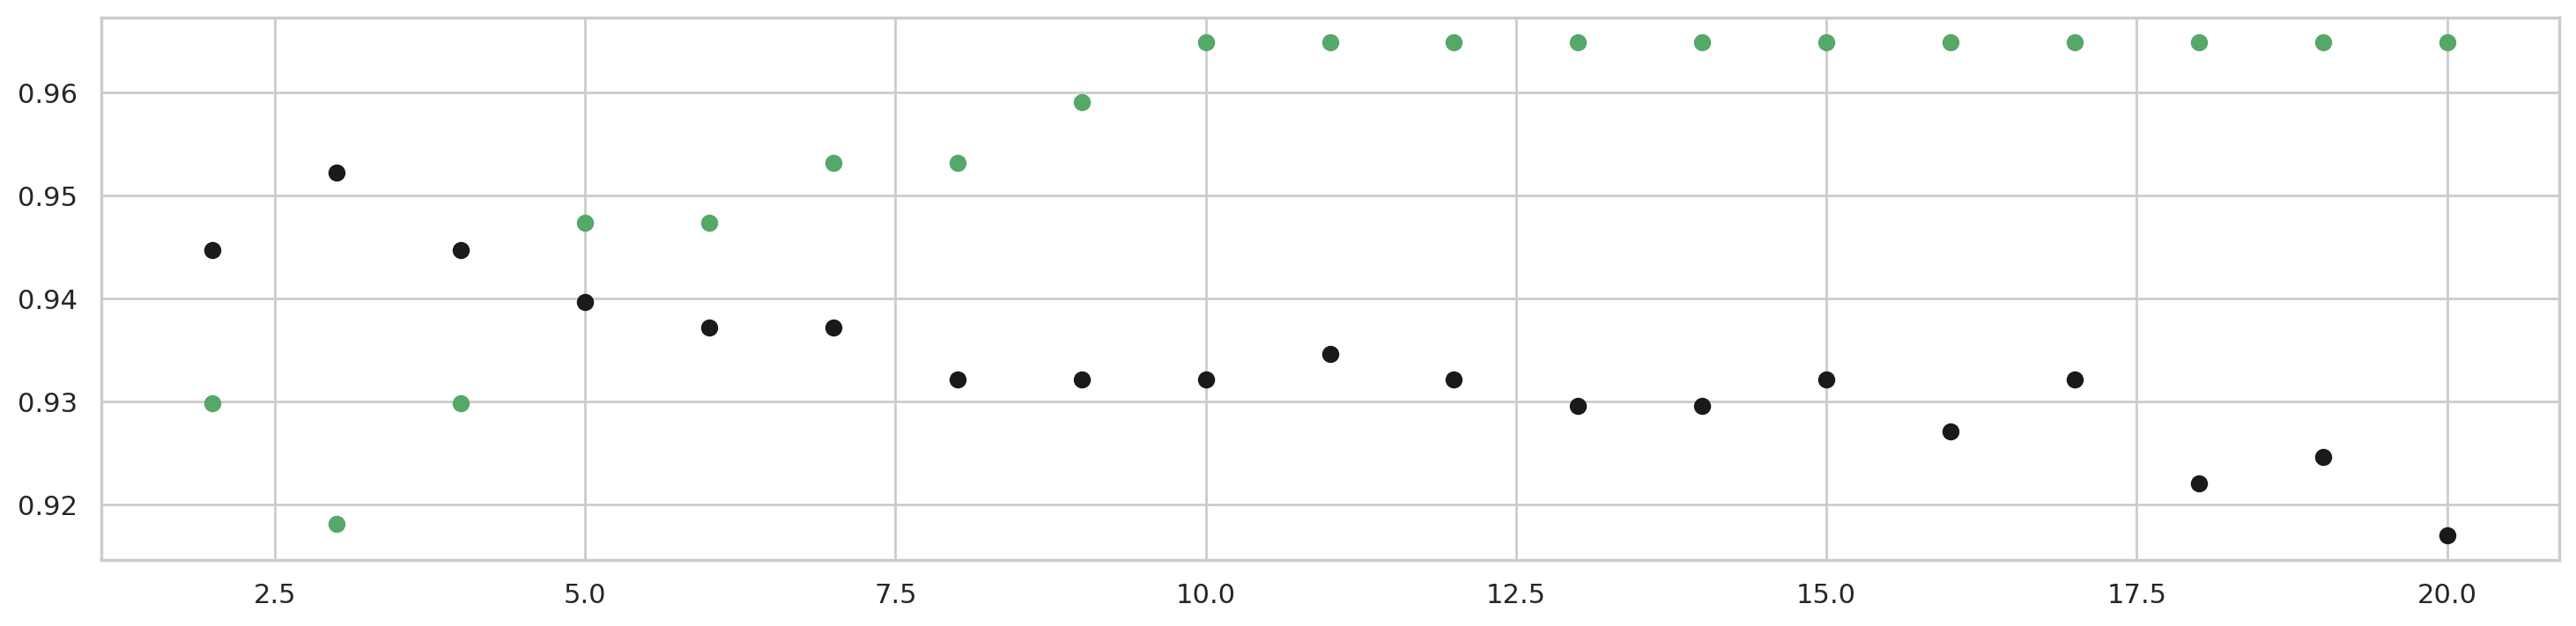

In [20]:
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()